In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [26]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)

In [27]:
# Select numerical columns that are relevant for VAE training
# features = ['Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'DM_SNR', 'DM_SNR_err', 'DM_alig', 'DM_alig_err', 'Flux_density', 
#             'Flux_density_err', 'Width', 'Width_err', 'Freq_high', 'Freq_low', 'Freq_peak', 'Fluence', 'Fluence_err', 'Energy', 
#             'Energy_err', 'Polar_l', 'Polar_l_err', 'Polar_c', 'Polar_c_err', 'RM_syn', 'RM_syn_err', 'RM_QUfit', 'RM_QUfit_err', 'Scatt_t', 'Scatt_t_err', 'Scin_f', 'Scin_f_err',]

labels = frb_data['Repeater']

features = ['Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'DM_SNR', 'DM_alig', 'Flux_density', 
             'Width', 'Freq_high', 'Freq_low', 'Freq_peak', 'Fluence', 'Energy', 
             'Polar_l',  'Polar_c', 'RM_syn',  'RM_QUfit', 'Scatt_t', 'Scin_f',]

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if type(value)==str and len(value.strip()) > 0:
        try:
            if '/' in value:
                value = value.split('/')[0]
            if '-' in value and not '+' in value:
                value = value.split('-')[0]
            if value[0] == '+':
                value = value[1:]
                value.split('/')
                value = value[0]
            if value[0] == '<':
                value = value[1:]
            if value[0] == '>':
                value = value[1:]
            return float(value)
        except:
            # print(f"Error: {value}")
            return np.nan
    try:
        return float(value)
    except:
        return np.nan

for col in frb_data[features].columns:
    frb_data[col] = frb_data[col].apply(clean_numeric_value)

In [28]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

train_data, val_data, train_labels, val_labels = train_test_split(
    frb_data_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [29]:
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, condition_dim=1, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(CVAE, self).__init__()
        
        self.activation = activation
        
        # Encoder: Input dimension is input_dim + condition_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder: Input dimension is latent_dim + condition_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x, c):
        # Concatenate data and condition along the feature dimension
        x = torch.cat([x, c], dim=1)
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        # Concatenate latent vector and condition
        z = torch.cat([z, c], dim=1)
        return self.decoder(z)
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar


In [30]:
reconstruction_loss_fn = torch.nn.MSELoss(reduction='sum')

def loss_function(recon_x, x, mean, logvar):
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = frb_data_scaled.shape[1]
hidden_dim = 256
latent_dim = 10
condition_dim = 1
patience = 4
num_epochs = 150


model = CVAE(input_dim, hidden_dim, latent_dim, condition_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [0/6931 (0%)]	Loss: 23.099579
Train Epoch: 1 [6400/6931 (92%)]	Loss: 11.978749
====> Epoch: 1 Average training loss: 20.2184, Reconstruction loss: 17.2803
====> Validation loss: 12.3208, Reconstruction loss: 9.4242
New best model saved with validation loss: 12.3208
Train Epoch: 2 [0/6931 (0%)]	Loss: 12.027792
Train Epoch: 2 [6400/6931 (92%)]	Loss: 15.974492
====> Epoch: 2 Average training loss: 16.8964, Reconstruction loss: 13.4334
====> Validation loss: 11.0944, Reconstruction loss: 8.4883
New best model saved with validation loss: 11.0944
Train Epoch: 3 [0/6931 (0%)]	Loss: 9.649096
Train Epoch: 3 [6400/6931 (92%)]	Loss: 13.121181
====> Epoch: 3 Average training loss: 15.5053, Reconstruction loss: 11.9779
====> Validation loss: 10.7944, Reconstruction loss: 8.2184
New best model saved with validation loss: 10.7944
Train Epoch: 4 [0/6931 (0%)]	Loss: 12.346608
Train Epoch: 4 [6400/6931 (92%)]	Loss: 9.114544
====> Epoch: 4 Average training loss: 14.7131, Reconstruction los

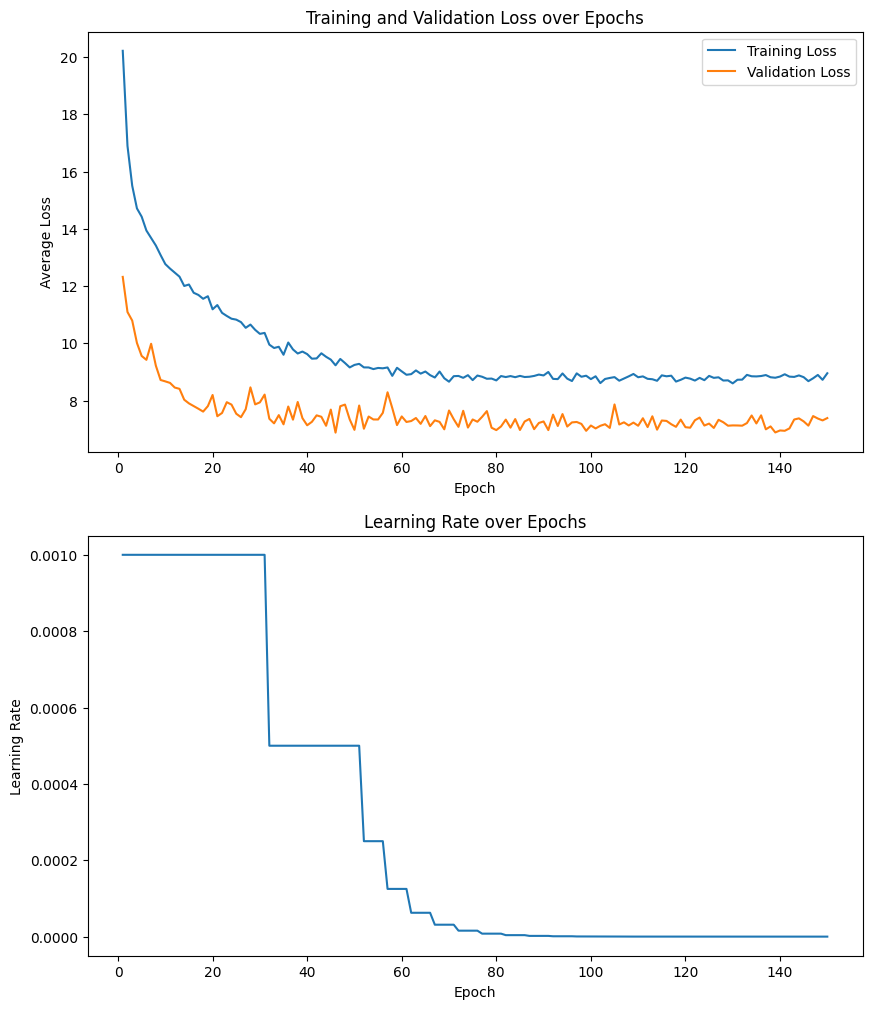

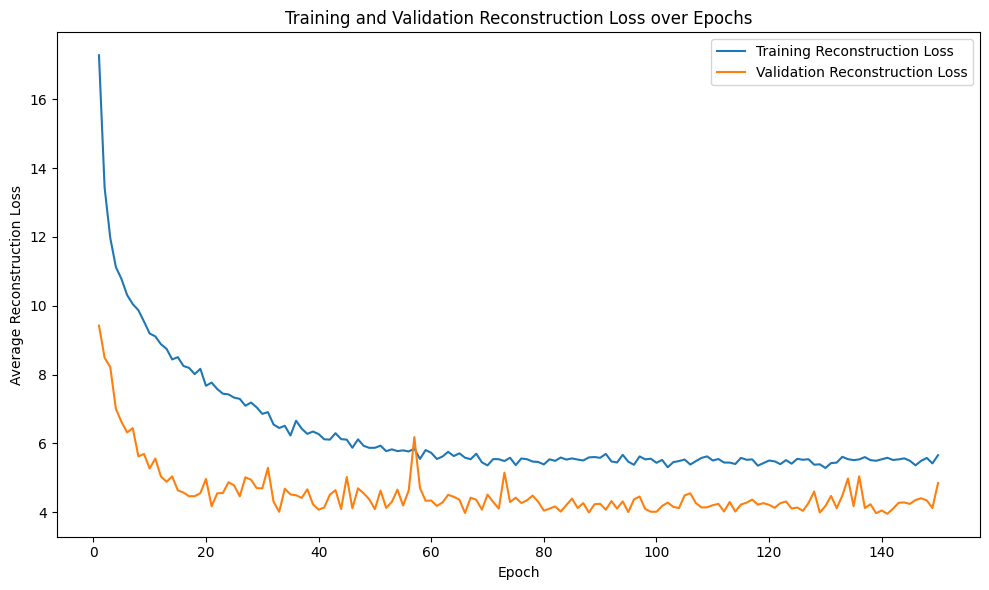

In [32]:
def train(epoch):
    model.train()
    train_loss = 0
    recon_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device).unsqueeze(1).float()  # Convert labels to (batch_size, 1) and make them float
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data, labels)  # Pass data and labels to model
        full_loss, recon_loss_val, kl_loss = loss_function(recon_batch, data, mu, logvar)
        full_loss.backward()
        train_loss += full_loss.item()
        recon_loss += recon_loss_val.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {full_loss.item() / len(data):.6f}')

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = recon_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average training loss: {avg_loss:.4f}, Reconstruction loss: {avg_recon_loss:.4f}')
    return avg_loss, avg_recon_loss

def validate():
    model.eval()
    val_loss = 0
    val_recon_loss = 0
    with torch.no_grad():
        for (data, labels) in val_loader:
            data = data.to(device)
            labels = labels.to(device).unsqueeze(1).float()  # Convert labels to (batch_size, 1)
            recon_batch, mu, logvar = model(data, labels)
            full_loss, recon_loss_val, kl_loss = loss_function(recon_batch, data, mu, logvar)
            val_loss += full_loss.item()
            val_recon_loss += recon_loss_val.item()

    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon_loss = val_recon_loss / len(val_loader.dataset)
    print(f'====> Validation loss: {avg_loss:.4f}, Reconstruction loss: {avg_recon_loss:.4f}')
    return avg_loss, avg_recon_loss

def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False

best_loss = float('inf')
train_losses, val_losses, learning_rates = [], [], []
train_recon_losses, val_recon_losses = [], []

# Training loop with early stopping and learning rate scheduling
for epoch in range(1, num_epochs + 1):
    train_loss, train_recon_loss = train(epoch)
    val_loss, val_recon_loss = validate()
    
    # Track losses and learning rates
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    train_recon_losses.append(train_recon_loss)
    val_recon_losses.append(val_recon_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'vae_best.pth')
        print(f"New best model saved with validation loss: {best_loss:.4f}")
    
    # Early stopping
    if early_stopping(val_losses, patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

print("Training complete.")

# Plot the training and validation loss and learning rate
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot training and validation loss
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss')
ax1.legend()

# Plot learning rate
ax2.plot(range(1, len(learning_rates) + 1), learning_rates)
ax2.set_title('Learning Rate over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')

# Plot the training and validation reconstruction loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(1, len(train_recon_losses) + 1), train_recon_losses, label='Training Reconstruction Loss')
ax.plot(range(1, len(val_recon_losses) + 1), val_recon_losses, label='Validation Reconstruction Loss')
ax.set_title('Training and Validation Reconstruction Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Reconstruction Loss')
ax.legend()

plt.tight_layout()
plt.show()

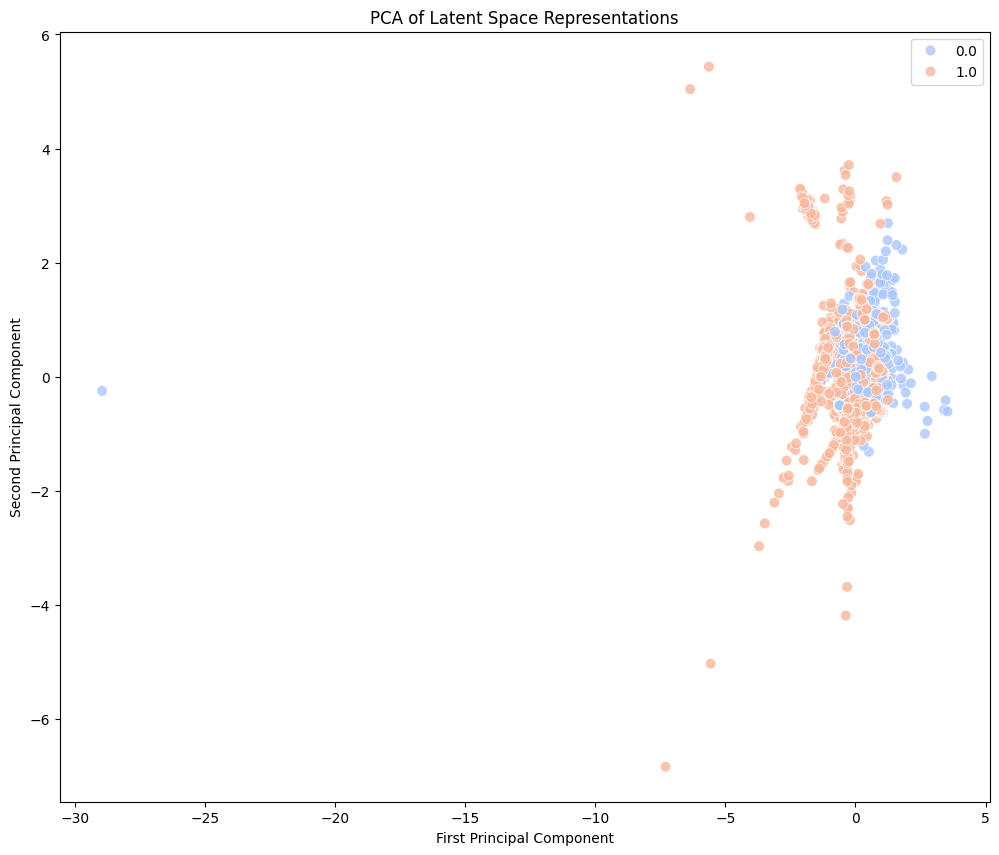

In [34]:
def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device).unsqueeze(1).float()  # Convert labels to (batch_size, 1)
            mu, _ = model.encode(data, labels)  # Pass labels to encoder
            latent_representations.append(mu.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.concatenate(latent_representations), np.concatenate(all_labels).flatten()

def visualize_latent_space_pca(latent_representations, labels):
    # Perform PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    # Plot the 2D latent space
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8)
    plt.title('PCA of Latent Space Representations')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

# Extract latent representations and visualize
train_latent, train_labels_np = get_latent_representations(model, train_loader, device)
visualize_latent_space_pca(train_latent, train_labels_np)

In [35]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(train_latent)
train_clusters = kmeans.labels_

sil_score = silhouette_score(train_latent, train_clusters)
ari_score = adjusted_rand_score(train_labels_np, train_clusters)

print(f"KMeans Silhouette Score: {sil_score:.4f}")
print(f"KMeans Adjusted Rand Index: {ari_score:.4f}")

conf_matrix = confusion_matrix(train_labels_np, train_clusters)
print("Confusion Matrix:")
print(conf_matrix)

KMeans Silhouette Score: 0.3091
KMeans Adjusted Rand Index: -0.0310
Confusion Matrix:
[[ 192  761]
 [1871 4107]]


In [36]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_clusters = gmm.fit_predict(train_latent)
sil_score = silhouette_score(train_latent, gmm_clusters)
ari_score = adjusted_rand_score(train_labels_np, gmm_clusters)
print(f"GMM Silhouette Score: {sil_score:.4f}")
print(f"GMM Adjusted Rand Index: {ari_score:.4f}")

conf_matrix = confusion_matrix(train_labels_np, gmm_clusters)
print("Confusion Matrix:")
print(conf_matrix)

GMM Silhouette Score: 0.3038
GMM Adjusted Rand Index: -0.0181
Confusion Matrix:
[[ 235  718]
 [1859 4119]]
